In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import random
from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel

from sgmcmcjax.optimizer import build_adam_optimizer

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, logloss_samples

from tuning.gridsearch import run_gridsearch

# Logistic regression: hyperparameter tuning

In [2]:


key = random.PRNGKey(42)
dim = 10
# Ndata = 100_000
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


In [3]:
Niters = 5000
batch_size = int(0.01*X_train.shape[0])
error_fn = lambda x: logloss_samples(x[::10], X_test, y_test)

key = random.PRNGKey(0)
key, subkey = random.split(key)
params_IC = 0.2*random.normal(subkey, shape=theta_true.shape) + theta_true

# get MAP
run_adam = build_adam_optimizer(1e-2, loglikelihood, logprior, data, batch_size)
centering_value, logpost_array = run_adam(key, Niters, jnp.zeros(dim))

logdt_range = -jnp.arange(1., 8., 0.5) 

In [4]:
logdt_range

DeviceArray([-1. , -1.5, -2. , -2.5, -3. , -3.5, -4. , -4.5, -5. , -5.5,
             -6. , -6.5, -7. , -7.5], dtype=float32)

## grid search

- sgld
- sgldCV
- sghmc
- sghmcCV
- sgnht
- sgnhtCV

Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 53 sec

Optimal hyperparameter: {'dt': 1e-06}


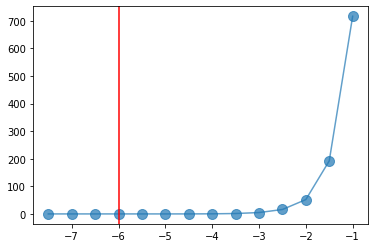

In [5]:
build_kernel = lambda dt: build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 87 sec

Optimal hyperparameter: {'dt': 1e-05}


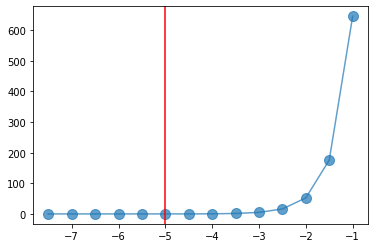

In [6]:
build_kernel = lambda dt: build_sgldCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

In [7]:
build_kernel = lambda dt, L: build_sghmc_kernel(dt, L, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range, "L": [5,10]}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, dt
Number of grid points: 28
{'L': 5, 'dt': 0.1}



{'L': 5, 'dt': 0.031622775}



{'L': 5, 'dt': 0.01}



{'L': 5, 'dt': 0.0031622776}



{'L': 5, 'dt': 0.001}



{'L': 5, 'dt': 0.00031622776}



{'L': 5, 'dt': 1e-04}



{'L': 5, 'dt': 3.1622778e-05}



{'L': 5, 'dt': 1e-05}



{'L': 5, 'dt': 3.1622776e-06}



{'L': 5, 'dt': 1e-06}



{'L': 5, 'dt': 3.1622776e-07}



{'L': 5, 'dt': 1e-07}



{'L': 5, 'dt': 3.1622776e-08}



{'L': 10, 'dt': 0.1}



{'L': 10, 'dt': 0.031622775}



{'L': 10, 'dt': 0.01}



{'L': 10, 'dt': 0.0031622776}



{'L': 10, 'dt': 0.001}



{'L': 10, 'dt': 0.00031622776}



{'L': 10, 'dt': 1e-04}



{'L': 10, 'dt': 3.1622778e-05}



{'L': 10, 'dt': 1e-05}



{'L': 10, 'dt': 3.1622776e-06}



{'L': 10, 'dt': 1e-06}



{'L': 10, 'dt': 3.1622776e-07}



{'L': 10, 'dt': 1e-07}



{'L': 10, 'dt': 3.1622776e-08}



Running time for gridsearch: 716 sec

Optimal hyperparameter: {'L': 10, 'dt': 1e-07}


In [9]:
build_kernel = lambda dt, L: build_sghmcCV_kernel(dt, L, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range, "L": [5,10]}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for L, dt
Number of grid points: 28
{'L': 5, 'dt': 0.1}



{'L': 5, 'dt': 0.031622775}



{'L': 5, 'dt': 0.01}



{'L': 5, 'dt': 0.0031622776}



{'L': 5, 'dt': 0.001}



{'L': 5, 'dt': 0.00031622776}



{'L': 5, 'dt': 1e-04}



{'L': 5, 'dt': 3.1622778e-05}



{'L': 5, 'dt': 1e-05}



{'L': 5, 'dt': 3.1622776e-06}



{'L': 5, 'dt': 1e-06}



{'L': 5, 'dt': 3.1622776e-07}



{'L': 5, 'dt': 1e-07}



{'L': 5, 'dt': 3.1622776e-08}



{'L': 10, 'dt': 0.1}



{'L': 10, 'dt': 0.031622775}



{'L': 10, 'dt': 0.01}



{'L': 10, 'dt': 0.0031622776}



{'L': 10, 'dt': 0.001}



{'L': 10, 'dt': 0.00031622776}



{'L': 10, 'dt': 1e-04}



{'L': 10, 'dt': 3.1622778e-05}



{'L': 10, 'dt': 1e-05}



{'L': 10, 'dt': 3.1622776e-06}



{'L': 10, 'dt': 1e-06}



{'L': 10, 'dt': 3.1622776e-07}



{'L': 10, 'dt': 1e-07}



{'L': 10, 'dt': 3.1622776e-08}



Running time for gridsearch: 739 sec

Optimal hyperparameter: {'L': 10, 'dt': 3.1622776e-07}


Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 88 sec

Optimal hyperparameter: {'dt': 3.1622776e-08}


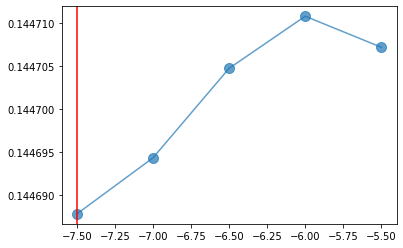

In [10]:
build_kernel = lambda dt: build_sgnht_kernel(dt, loglikelihood, logprior, data, batch_size)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")

Running gridsearch for dt
Number of grid points: 14
{'dt': 0.1}



{'dt': 0.031622775}



{'dt': 0.01}



{'dt': 0.0031622776}



{'dt': 0.001}



{'dt': 0.00031622776}



{'dt': 1e-04}



{'dt': 3.1622778e-05}



{'dt': 1e-05}



{'dt': 3.1622776e-06}



{'dt': 1e-06}



{'dt': 3.1622776e-07}



{'dt': 1e-07}



{'dt': 3.1622776e-08}



Running time for gridsearch: 105 sec

Optimal hyperparameter: {'dt': 3.1622778e-05}


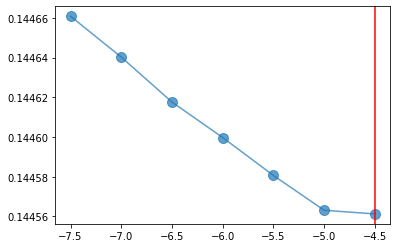

In [11]:
build_kernel = lambda dt: build_sgnhtCV_kernel(dt, loglikelihood, logprior, data, batch_size, centering_value)

grid_params = {'log_dt': logdt_range}
list_hyperparams, ll_list = run_gridsearch(key, build_kernel, error_fn, Niters, params_IC, grid_params)

log_dt_grid = [np.log10(elem['dt']) for elem in list_hyperparams]
plt.plot(log_dt_grid, ll_list, marker="o", markersize=10, alpha=0.7)
plt.axvline(log_dt_grid[np.nanargmin(ll_list)], c='r')

print(f"\nOptimal hyperparameter: {list_hyperparams[np.nanargmin(ll_list)]}")